In [67]:
import gzip
from io import StringIO
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import re
import string
import json
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim import matutils

In [3]:
def gzip_file_to_documents_list(file_name, languages_filter=['en']):
    with gzip.open(file_name, 'rb') as f:
        decompressed_data = f.read()
    df_data = pd.read_csv(StringIO(str(decompressed_data,'utf-8')), index_col=0)
    documents = df_data[df_data['language'].isin(languages_filter)]['text'].tolist()
    return documents

In [4]:
def uctd_file_name_by_date(month, day):
    return '0'*int(month < 10) + str(month) + '0'*int(day < 10) + str(day) + "_UkraineCombinedTweetsDeduped.csv.gzip"

In [5]:
def get_uctd_documents_between_dates(start: str, end: str,
                                     languages_filter=['en'], verbose: int = 0):
    # Dates in the 'YYYY-DD-MM' format
    date_start = datetime.strptime(start, '%Y-%m-%d')
    date_end = datetime.strptime(end, '%Y-%m-%d')
    delta_days = date_end - date_start
    all_documents = []
    for i_d in range(delta_days.days + 1):
        date_current = date_start + timedelta(days=i_d)
        uctd_file_name = uctd_file_name_by_date(date_current.month, date_current.day)
        all_documents += gzip_file_to_documents_list(uctd_file_name, languages_filter=languages_filter)
        if verbose == 1:
            print(f'--Documents for the day {date_current.date()} processed')
    return all_documents

In [6]:
all_documents_0922_uk = get_uctd_documents_between_dates('2022-09-01','2022-09-30',
                                                         languages_filter=['uk'],verbose=1)

--Documents for the day 2022-09-01 processed
--Documents for the day 2022-09-02 processed
--Documents for the day 2022-09-03 processed
--Documents for the day 2022-09-04 processed
--Documents for the day 2022-09-05 processed
--Documents for the day 2022-09-06 processed
--Documents for the day 2022-09-07 processed
--Documents for the day 2022-09-08 processed
--Documents for the day 2022-09-09 processed
--Documents for the day 2022-09-10 processed
--Documents for the day 2022-09-11 processed
--Documents for the day 2022-09-12 processed
--Documents for the day 2022-09-13 processed
--Documents for the day 2022-09-14 processed
--Documents for the day 2022-09-15 processed
--Documents for the day 2022-09-16 processed
--Documents for the day 2022-09-17 processed
--Documents for the day 2022-09-18 processed
--Documents for the day 2022-09-19 processed
--Documents for the day 2022-09-20 processed
--Documents for the day 2022-09-21 processed
--Documents for the day 2022-09-22 processed
--Document

In [17]:
from stop_words import get_stop_words

stop_words = get_stop_words('en')

In [55]:
class UkrainianPreprocessor:
    def preprocess_documents(self, documents_list: list, return_strings: bool = True):
        return [self.preprocess(doc, return_string=return_strings) for doc in documents_list]
    
    # Function to preprocess documents
    def preprocess(self, document, return_string: bool = True):
        # Tokenize
        document = self.remove_links_content(document)
        document = self.remove_emails(document)
        document = self.remove_multiple_space(document)
        document = self.remove_hashtags(document)
        document = self.remove_punctuation(document)
        document = self.remove_multiple_space(document)
        
        words = word_tokenize(document.lower())
        # Remove stopwords and punctuations
        filtered_words = [word for word in words if word.isalnum() and not word in stop_words]
        # Lemmatize
        lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]
        if return_string:
            return ' '.join(lemmatized_words)
        else:
            return lemmatized_words
    
    def remove_links_content(self, text):
        text = re.sub(r"http\S+", "", text)
        return text
    
    def remove_emails(self, text):
        return re.sub('\S+@\S*\s?', '', text)
    
    def remove_punctuation(self, text):
        """https://stackoverflow.com/a/37221663"""
        table = str.maketrans({key: None for key in string.punctuation})
        return text.translate(table)
    
    def remove_multiple_space(self, text):
        return re.sub("\s\s+", " ", text)

    def remove_hashtags(self, text):
        old_text = text + '\n'
        new_text = text
        while len(new_text) < len(old_text):
            old_text = new_text
            new_text = re.sub('(?<=[\s\n])#\S+\s*$', '', new_text)
        return new_text

In [23]:
class LSAPipelineUkrainian:
    def __init__(self, documents_list, tf_idf_max_df=1.0, tf_idf_min_df=1,
                 lsa_components: int = 100, svd_n_iter: int = 5,
                 n_top_words: int = 10, ngram_range: tuple = (1, 1),
                 random_state: int = -1):
        self.import_documents_list = UkrainianPreprocessor().preprocess_documents(documents_list)
        self.tf_idf_max_df = tf_idf_max_df
        self.tf_idf_min_df = tf_idf_min_df
        self.lsa_components = lsa_components
        self.svd_n_iter = svd_n_iter
        self.n_top_words = n_top_words
        self.ngram_range = ngram_range
        self.random_state = random_state
        self.coherence_texts_calculated = False

    def run_topics_detection(self):
        tfidf_documents = self.TF_IDF()
        self.TruncatedSVD(tfidf_documents)
        self.topics = self.find_topics()
        return self.topics

    def transform_documents(self, new_documents_list: list):
        return list(map(np.argmax, self.svd_model.transform(
            self.tfidf_vectorizer.transform(new_documents_list))))

    def import_ready_documents(self, documents_list, texts, dictionary, corpus):
        self.import_documents_list = documents_list
        self.texts = texts
        self.dictionary = dictionary
        self.corpus = corpus
        self.coherence_texts_calculated = True

    def TF_IDF(self):
        self.tfidf_vectorizer = TfidfVectorizer(max_df=self.tf_idf_max_df,
                                                min_df=self.tf_idf_min_df,
                                                ngram_range=self.ngram_range,
                                                stop_words=stop_words)
        return self.tfidf_vectorizer.fit_transform(self.import_documents_list)
        # tfidf_feature_names = self.tfidf_vectorizer.get_feature_names_out()
    
    def TruncatedSVD(self, tfidf_documents):
        if self.random_state != -1:
            self.svd_model = TruncatedSVD(n_components=self.lsa_components,
                                 n_iter=self.svd_n_iter, random_state=self.random_state)
        else:
            self.svd_model = TruncatedSVD(n_components=self.lsa_components,
                                 n_iter=self.svd_n_iter)
        self.svd_model.fit_transform(tfidf_documents)

    def find_topics(self):
        # Extract the top words for each topic
        topics = []
        tfidf_feature_names = self.tfidf_vectorizer.get_feature_names_out()
        for topic_idx, topic in enumerate(self.svd_model.components_):
            top_features_ind = topic.argsort()[:-self.n_top_words - 1:-1]
            top_features = [tfidf_feature_names[i] for i in top_features_ind]
            topics.append(top_features)
        return topics

    def calculate_coherence_score(self, recalculate_texts: bool = False, verbose: int = 0):
        if not self.coherence_texts_calculated or recalculate_texts:
            self.calculate_coherence_texts(verbose=verbose)
        # Calculate the coherence score using Gensim
        coherence_model = CoherenceModel(topics=self.topics,
                                         texts=self.texts,
                                         dictionary=self.dictionary,
                                         coherence='c_v')
        if verbose == 1:
            print(f'--Calculating the coherence score')
        self.coherence_score = coherence_model.get_coherence()
        return self.coherence_score

    def calculate_coherence_texts(self, verbose: int = 0):
        # Convert the list of top words into a list of lists of words
        tfidf_feature_names = set(self.tfidf_vectorizer.get_feature_names_out())
        if verbose == 1:
            print(f'--Starting forming the texts')
        self.texts = [[word for word in doc.lower().split() if (
            word in tfidf_feature_names)] for doc in self.import_documents_list]
        # Create a Gensim dictionary
        if verbose == 1:
            print(f'--Creating the Gensim dectionary')
        self.dictionary = Dictionary(self.texts)
        # Convert the dictionary and the corpus
        if verbose == 1:
            print(f'--Converting to the corpus')
        self.corpus = [dictionary.doc2bow(text) for text in self.texts]
        self.coherence_texts_calculated = True

In [28]:
def tokenize_ngrams(document, n_g):
    return [' '.join(ngram) for ngram in ngrams(document.lower().split(), n_g)]

In [21]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/oleksii/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/oleksii/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [18]:
lemmatizer = WordNetLemmatizer()

In [24]:
LSAPipeline = LSAPipelineUkrainian(all_documents_0922_uk, tf_idf_max_df=0.9, tf_idf_min_df=4,
                                 lsa_components=5, svd_n_iter=5,
                                 n_top_words=10, ngram_range=(1,2),
                                 random_state=47)
topics = LSAPipeline.run_topics_detection()

/home/oleksii/UCU/ucu_env/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'can', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


In [31]:
topics

[['путін ukrainian',
  'ідіть ебать',
  'себе путін',
  'ебать себе',
  'ебать',
  'ідіть',
  'ukrainian',
  'путін',
  'себе',
  'не'],
 ['не', 'на', 'це', 'що', 'як', 'так', 'та', 'але', 'за', 'до'],
 ['дякую',
  'дякую за',
  'за',
  'дуже дякую',
  'дуже',
  'дякую що',
  'дякую вам',
  'вам',
  'пане',
  'дякую пане'],
 ['війна анімація',
  'отже війна',
  'анімація',
  'отже',
  'війна',
  'слава',
  'україні',
  'слава україні',
  'ти',
  'ukraine'],
 ['соловїною підписатись',
  'дня соловїною',
  'підписатись адвокат',
  'соловїною',
  'адвокат',
  'підписатись',
  'дня',
  'слава',
  'слава україні',
  'україні']]

In [25]:
tfidf_feature_names = set(LSAPipeline.tfidf_vectorizer.get_feature_names_out())
preprocessed_documents = LSAPipeline.import_documents_list

In [38]:
all_documents_0922_uk[0]

'Міноборони передало до парламенту пропозиції змін до закону про військовий обов’язок щодо добровільності постановки на військовий облік жінок https://t.co/Sh7QfRjxqG #ukraine'

In [39]:
preprocessed_documents[0]

'міноборони передало до парламенту пропозиції змін до закону про військовий обов язок щодо добровільності постановки на військовий облік жінок'

In [29]:
# Convert the list of ngrams into a list of lists of words
texts_v4 = [[word for word in doc.lower().split() if (
    word in tfidf_feature_names)] + tokenize_ngrams(doc, 2) for doc in preprocessed_documents]

# Create a Gensim dictionary
dictionary_v4 = Dictionary(texts_v4)

# Convert the dictionary and the corpus
corpus_v4 = [dictionary_v4.doc2bow(text) for text in texts_v4]

In [34]:
# Calculate the coherence score using Gensim
coherence_model = CoherenceModel(topics=topics,
                                 texts=texts_v4,
                                 dictionary=dictionary_v4,
                                 corpus=corpus_v4,
                                 coherence='c_v')
coherence_score = coherence_model.get_coherence()

print('Coherence Score:', coherence_score)

Coherence Score: 0.5349934782635805


## 1- and 2-grams: optimal topics number

Model that uses both 1- and 2-grams for the different topics numbers for the data for September 2022 in Ukrainian language.

In [35]:
topic_numbers_12grams = list(range(2,15)) + [20,30,40,50,100,150,200]
coherences_12grams = []
predicted_topics_counts_12grams = []
for topic_number in topic_numbers_12grams:
    LSAPipeline = LSAPipelineUkrainian(all_documents_0922_uk, tf_idf_max_df=0.9, tf_idf_min_df=4,
                                 lsa_components=topic_number, svd_n_iter=5,
                                 n_top_words=10, ngram_range=(1,2),
                                 random_state=47)
    topics_12grams = LSAPipeline.run_topics_detection()
    tfidf_feature_names = set(LSAPipeline.tfidf_vectorizer.get_feature_names_out())
    # Calculate the coherence score using Gensim
    coherence_model = CoherenceModel(topics=topics_12grams,
                                     texts=texts_v4,
                                     dictionary=dictionary_v4,
                                     corpus=corpus_v4,
                                     coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    predicted_topics = LSAPipeline.transform_documents(LSAPipeline.import_documents_list)
    predicted_topics_count = [predicted_topics.count(x) for x in np.sort(np.unique(predicted_topics))]
    
    print(f'--Topic number {topic_number} coherence score: {coherence_score}')
    coherences_12grams.append(coherence_score)
    predicted_topics_counts_12grams.append(predicted_topics_count)

--Topic number 2 coherence score: 0.7049454799307205
--Topic number 3 coherence score: 0.667638843216167
--Topic number 4 coherence score: 0.5617154300033507
--Topic number 5 coherence score: 0.5349934782635805
--Topic number 6 coherence score: 0.5689534443157522
--Topic number 7 coherence score: 0.6329268395815847
--Topic number 8 coherence score: 0.5999801947888078
--Topic number 9 coherence score: 0.585342701931277
--Topic number 10 coherence score: 0.5733053987225315
--Topic number 11 coherence score: 0.567854434888853
--Topic number 12 coherence score: 0.5554819209012852
--Topic number 13 coherence score: 0.5963965803373524
--Topic number 14 coherence score: 0.5332148373432543
--Topic number 20 coherence score: 0.523798726405071
--Topic number 30 coherence score: 0.5262199590052327
--Topic number 40 coherence score: 0.518210233045419
--Topic number 50 coherence score: 0.5150692067497479
--Topic number 100 coherence score: 0.4772828470753781
--Topic number 150 coherence score: 0.44

In [36]:
with open('coherences_12grams_uk.json','w') as json_file:
    json.dump({'coherences': coherences_12grams,
               'predicted_topics': predicted_topics_counts_12grams}, json_file)

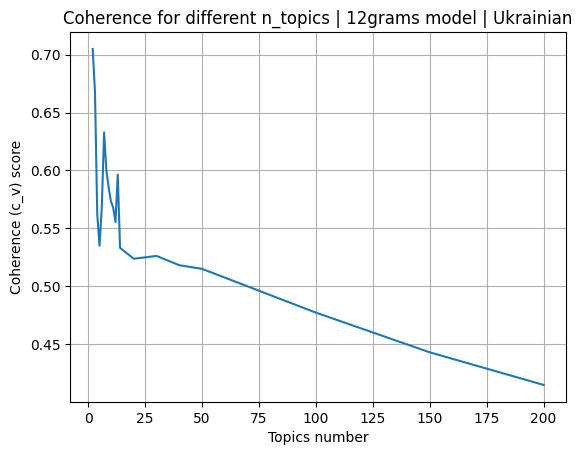

In [37]:
plt.plot(topic_numbers_12grams, coherences_12grams)
plt.title('Coherence for different n_topics | 12grams model | Ukrainian')
plt.xlabel('Topics number')
plt.ylabel('Coherence (c_v) score')
plt.grid()
plt.show()

# New preprocessing

The old lemmatization and tokenization procedures for Ukrainian don't seem ideal. Let's improve them a bit and observe how it impacts the performance.

In [40]:
all_documents_0922_uk[:5]

['Міноборони передало до парламенту пропозиції змін до закону про військовий обов’язок щодо добровільності постановки на військовий облік жінок https://t.co/Sh7QfRjxqG #ukraine',
 'Якшо чесно, я сумніваюсь в її реальності✨🤲🏼 https://t.co/Lp4e31WhJ2',
 'Додав трохи фотошопу... Джонні не знав на що підписався https://t.co/7id1m1Zt68',
 'Дива трапляються... Дякую за запрошення Alessio Carbone, хореограф у Артему Шошину та партнеру Олексію Потьомкіну 💕💕💕💕 🇺🇦🇺🇦🇮🇹🇮🇹#ballet #balletukraine #yevheniiakorshunova #oleksiipotomkin #artemshoshyn #itali #ballerina #Ukraine️ #Ukraine️ https://t.co/XozJ9ANtAZ',
 'о третій ночі зловила повітряну тривогу, така гучна, я трошки не була готова ще🥲']

In [41]:
UkrainianPreprocessor().preprocess_documents(all_documents_0922_uk[:5])

['міноборони передало до парламенту пропозиції змін до закону про військовий обов язок щодо добровільності постановки на військовий облік жінок',
 'якшо чесно я сумніваюсь в її',
 'додав трохи фотошопу джонні не знав на що підписався',
 'дива трапляються дякую за запрошення alessio carbone хореограф у артему шошину та партнеру олексію потьомкіну',
 'о третій ночі зловила повітряну тривогу така гучна я трошки не була готова']

New lemmatizer using the [stanza](https://stanfordnlp.github.io/stanza/) library:

In [43]:
import stanza

In [44]:
stanza.download('uk')

2024-03-15 09:02:34 INFO: Downloading default packages for language: uk (Ukrainian) ...
2024-03-15 09:02:35 INFO: File exists: /home/oleksii/stanza_resources/uk/default.zip
2024-03-15 09:02:38 INFO: Finished downloading models and saved to /home/oleksii/stanza_resources.


In [45]:
stanza_pip = stanza.Pipeline(lang='uk', processors='tokenize,mwt,pos,lemma')

2024-03-15 09:02:57 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-03-15 09:02:58 INFO: Loading these models for language: uk (Ukrainian):
| Processor | Package     |
---------------------------
| tokenize  | iu          |
| mwt       | iu          |
| pos       | iu_charlm   |
| lemma     | iu_nocharlm |

2024-03-15 09:02:58 INFO: Using device: cpu
2024-03-15 09:02:58 INFO: Loading: tokenize
2024-03-15 09:02:58 INFO: Loading: mwt
2024-03-15 09:02:58 INFO: Loading: pos
2024-03-15 09:02:59 INFO: Loading: lemma
2024-03-15 09:02:59 INFO: Done loading processors!


In [46]:
all_documents_0922_uk[0]

'Міноборони передало до парламенту пропозиції змін до закону про військовий обов’язок щодо добровільності постановки на військовий облік жінок https://t.co/Sh7QfRjxqG #ukraine'

In [49]:
doc = stanza_pip(all_documents_0922_uk[0])
print(*[f'word: {word.text+" ":15}\tlemma: {word.lemma}' for sent in doc.sentences for word in sent.words], sep='\n')

word: Міноборони     	lemma: міноборон
word: передало       	lemma: передати
word: до             	lemma: до
word: парламенту     	lemma: парламент
word: пропозиції     	lemma: пропозиція
word: змін           	lemma: зміна
word: до             	lemma: до
word: закону         	lemma: закон
word: про            	lemma: про
word: військовий     	lemma: військовий
word: обов’язок      	lemma: обов’язка
word: щодо           	lemma: щодо
word: добровільності 	lemma: добровільність
word: постановки     	lemma: постановка
word: на             	lemma: на
word: військовий     	lemma: військовий
word: облік          	lemma: облік
word: жінок          	lemma: жінка
word: https://t.co/Sh7QfRjxqG 	lemma: https://t.co/Sh7QfRjxqG
word: #              	lemma: #
word: ukraine        	lemma: ukraine
Міноборони передало до парламенту пропозиції змін до закону про військовий обов’язок щодо добровільності постановки на військовий облік жінок https://t.co/Sh7QfRjxqG #ukraine


In [54]:
print([word for sent in doc.sentences for word in sent.words])

[{
  "id": 1,
  "text": "Міноборони",
  "lemma": "міноборон",
  "upos": "NOUN",
  "xpos": "Ncmpnn",
  "feats": "Animacy=Inan|Case=Nom|Gender=Masc|Number=Plur",
  "start_char": 0,
  "end_char": 10
}, {
  "id": 2,
  "text": "передало",
  "lemma": "передати",
  "upos": "VERB",
  "xpos": "Vmeis-sn",
  "feats": "Aspect=Perf|Gender=Neut|Mood=Ind|Number=Sing|Tense=Past|VerbForm=Fin",
  "start_char": 11,
  "end_char": 19
}, {
  "id": 3,
  "text": "до",
  "lemma": "до",
  "upos": "ADP",
  "xpos": "Spsg",
  "feats": "Case=Gen",
  "start_char": 20,
  "end_char": 22
}, {
  "id": 4,
  "text": "парламенту",
  "lemma": "парламент",
  "upos": "NOUN",
  "xpos": "Ncmsgn",
  "feats": "Animacy=Inan|Case=Gen|Gender=Masc|Number=Sing",
  "start_char": 23,
  "end_char": 33
}, {
  "id": 5,
  "text": "пропозиції",
  "lemma": "пропозиція",
  "upos": "NOUN",
  "xpos": "Ncfpan",
  "feats": "Animacy=Inan|Case=Acc|Gender=Fem|Number=Plur",
  "start_char": 34,
  "end_char": 44
}, {
  "id": 6,
  "text": "змін",
  "lemm

In [51]:
print([word.lemma for sent in doc.sentences for word in sent.words])

['міноборон', 'передати', 'до', 'парламент', 'пропозиція', 'зміна', 'до', 'закон', 'про', 'військовий', 'обов’язка', 'щодо', 'добровільність', 'постановка', 'на', 'військовий', 'облік', 'жінка', 'https://t.co/Sh7QfRjxqG', '#', 'ukraine']


In [56]:
class UkrainianPreprocessor_v2:
    def preprocess_documents(self, documents_list: list, return_strings: bool = True):
        return [self.preprocess(doc, return_string=return_strings) for doc in documents_list]
    
    # Function to preprocess documents
    def preprocess(self, document, return_string: bool = True):
        # Clean the document
        document = self.remove_links_content(document)
        document = self.remove_emails(document)
        document = self.remove_multiple_space(document)
        document = self.remove_hashtags(document)
        document = self.remove_punctuation(document)
        document = self.remove_multiple_space(document)
        
        # Tokenize and lemmatize
        processed_document = stanza_pip(document.lower())
        lemmatized_words = [word.lemma for sent in processed_document.sentences for word in sent.words]
        # Remove stopwords and punctuations
        filtered_words = [word for word in lemmatized_words if word.isalnum() and not word in stop_words]
        if return_string:
            return ' '.join(lemmatized_words)
        else:
            return lemmatized_words
    
    def remove_links_content(self, text):
        text = re.sub(r"http\S+", "", text)
        return text
    
    def remove_emails(self, text):
        return re.sub('\S+@\S*\s?', '', text)
    
    def remove_punctuation(self, text):
        """https://stackoverflow.com/a/37221663"""
        table = str.maketrans({key: None for key in string.punctuation})
        return text.translate(table)
    
    def remove_multiple_space(self, text):
        return re.sub("\s\s+", " ", text)

    def remove_hashtags(self, text):
        old_text = text + '\n'
        new_text = text
        while len(new_text) < len(old_text):
            old_text = new_text
            new_text = re.sub('(?<=[\s\n])#\S+\s*$', '', new_text)
        return new_text

In [64]:
# Old and preprocessing comparison
for i_d, document in enumerate(all_documents_0922_uk[:5]):
    print(f'--Document {i_d}:')
    print(f'--Old processing: {UkrainianPreprocessor().preprocess_documents([document])[0]}')
    print(f'--New processing: {UkrainianPreprocessor_v2().preprocess_documents([document])[0]}\n')

--Document 0:
--Old processing: міноборони передало до парламенту пропозиції змін до закону про військовий обов язок щодо добровільності постановки на військовий облік жінок
--New processing: міноборони передати до парламент пропозиція зміна до закон про військовий обов’язка щодо добровільність постановка на військовий облік жінка

--Document 1:
--Old processing: якшо чесно я сумніваюсь в її
--New processing: якшо чесно я сумніватися в її реальності✨🤲 🏼

--Document 2:
--Old processing: додав трохи фотошопу джонні не знав на що підписався
--New processing: додати трохи фотошоп джоння не знати на що підписатися

--Document 3:
--Old processing: дива трапляються дякую за запрошення alessio carbone хореограф у артему шошину та партнеру олексію потьомкіну
--New processing: диво траплятися дякувати за запрошення alessio carbone хореограф у артем шошин та партнер олексія потьомкін 💕💕💕💕 🇺🇦🇺🇦🇮🇹🇮 🇹ballet

--Document 4:
--Old processing: о третій ночі зловила повітряну тривогу така гучна я трошки 

## 1- and 2-grams with the new processing: optimal topics number

Model that uses both 1- and 2-grams with the new preprocessing for the different topics numbers for the data for September 2022 in Ukrainian language.

In [65]:
# The new preprocessing class is now our main one
class UkrainianPreprocessor:
    def preprocess_documents(self, documents_list: list, return_strings: bool = True):
        return [self.preprocess(doc, return_string=return_strings) for doc in documents_list]
    
    # Function to preprocess documents
    def preprocess(self, document, return_string: bool = True):
        # Clean the document
        document = self.remove_links_content(document)
        document = self.remove_emails(document)
        document = self.remove_multiple_space(document)
        document = self.remove_hashtags(document)
        document = self.remove_punctuation(document)
        document = self.remove_multiple_space(document)
        
        # Tokenize and lemmatize
        processed_document = stanza_pip(document.lower())
        lemmatized_words = [word.lemma for sent in processed_document.sentences for word in sent.words]
        # Remove stopwords and punctuations
        filtered_words = [word for word in lemmatized_words if word.isalnum() and not word in stop_words]
        if return_string:
            return ' '.join(lemmatized_words)
        else:
            return lemmatized_words
    
    def remove_links_content(self, text):
        text = re.sub(r"http\S+", "", text)
        return text
    
    def remove_emails(self, text):
        return re.sub('\S+@\S*\s?', '', text)
    
    def remove_punctuation(self, text):
        """https://stackoverflow.com/a/37221663"""
        table = str.maketrans({key: None for key in string.punctuation})
        return text.translate(table)
    
    def remove_multiple_space(self, text):
        return re.sub("\s\s+", " ", text)

    def remove_hashtags(self, text):
        old_text = text + '\n'
        new_text = text
        while len(new_text) < len(old_text):
            old_text = new_text
            new_text = re.sub('(?<=[\s\n])#\S+\s*$', '', new_text)
        return new_text

In [ ]:
topic_numbers_12grams = list(range(2,15)) + [20,30,40,50,100,150,200]
coherences_12grams = []
predicted_topics_counts_12grams = []
for topic_number in topic_numbers_12grams:
    LSAPipeline = LSAPipelineUkrainian(all_documents_0922_uk, tf_idf_max_df=0.9, tf_idf_min_df=4,
                                 lsa_components=topic_number, svd_n_iter=5,
                                 n_top_words=10, ngram_range=(1,2),
                                 random_state=47)
    topics_12grams = LSAPipeline.run_topics_detection()
    tfidf_feature_names = set(LSAPipeline.tfidf_vectorizer.get_feature_names_out())
    # Calculate the coherence score using Gensim
    coherence_model = CoherenceModel(topics=topics_12grams,
                                     texts=texts_v4,
                                     dictionary=dictionary_v4,
                                     corpus=corpus_v4,
                                     coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    predicted_topics = LSAPipeline.transform_documents(LSAPipeline.import_documents_list)
    predicted_topics_count = [predicted_topics.count(x) for x in np.sort(np.unique(predicted_topics))]
    
    print(f'--Topic number {topic_number} coherence score: {coherence_score}')
    coherences_12grams.append(coherence_score)
    predicted_topics_counts_12grams.append(predicted_topics_count)

In [35]:
topic_numbers_12grams = list(range(2,15)) + [20,30,40,50,100,150,200]
coherences_12grams = []
predicted_topics_counts_12grams = []
for topic_number in topic_numbers_12grams:
    LSAPipeline = LSAPipelineUkrainian(all_documents_0922_uk, tf_idf_max_df=0.9, tf_idf_min_df=4,
                                 lsa_components=topic_number, svd_n_iter=5,
                                 n_top_words=10, ngram_range=(1,2),
                                 random_state=47)
    topics_12grams = LSAPipeline.run_topics_detection()
    tfidf_feature_names = set(LSAPipeline.tfidf_vectorizer.get_feature_names_out())
    # Calculate the coherence score using Gensim
    coherence_model = CoherenceModel(topics=topics_12grams,
                                     texts=texts_v4,
                                     dictionary=dictionary_v4,
                                     corpus=corpus_v4,
                                     coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    predicted_topics = LSAPipeline.transform_documents(LSAPipeline.import_documents_list)
    predicted_topics_count = [predicted_topics.count(x) for x in np.sort(np.unique(predicted_topics))]
    
    print(f'--Topic number {topic_number} coherence score: {coherence_score}')
    coherences_12grams.append(coherence_score)
    predicted_topics_counts_12grams.append(predicted_topics_count)

--Topic number 2 coherence score: 0.7049454799307205
--Topic number 3 coherence score: 0.667638843216167
--Topic number 4 coherence score: 0.5617154300033507
--Topic number 5 coherence score: 0.5349934782635805
--Topic number 6 coherence score: 0.5689534443157522
--Topic number 7 coherence score: 0.6329268395815847
--Topic number 8 coherence score: 0.5999801947888078
--Topic number 9 coherence score: 0.585342701931277
--Topic number 10 coherence score: 0.5733053987225315
--Topic number 11 coherence score: 0.567854434888853
--Topic number 12 coherence score: 0.5554819209012852
--Topic number 13 coherence score: 0.5963965803373524
--Topic number 14 coherence score: 0.5332148373432543
--Topic number 20 coherence score: 0.523798726405071
--Topic number 30 coherence score: 0.5262199590052327
--Topic number 40 coherence score: 0.518210233045419
--Topic number 50 coherence score: 0.5150692067497479
--Topic number 100 coherence score: 0.4772828470753781
--Topic number 150 coherence score: 0.44

In [ ]:
with open('coherences_12grams_uk_new.json','w') as json_file:
    json.dump({'coherences': coherences_12grams,
               'predicted_topics': predicted_topics_counts_12grams}, json_file)

In [ ]:
plt.plot(topic_numbers_12grams, coherences_12grams)
plt.title('Coherence for different n_topics | 12grams model, new preprocessing | Ukrainian')
plt.xlabel('Topics number')
plt.ylabel('Coherence (c_v) score')
plt.grid()
plt.show()

# 1- and 2-grams with the new processing, only certain PoS

Let's biuld a model that performa topic modelling only gfor the certain most important parts of speech (PoS), starting with the nouns, verbs, adjectives, and adverbs. We have such an information thanks to using the `stanza` pipeline. The motivation behind this is that the most important speech parts may store the most information about the document'ds idea and purpose, which is even more important in the case of the tweets.

We'll later likely return to review the models based only a single PoS, like, for example, nouns. This can also be useful to detect spam in the messages, and adjectives can potentially be useful in detecting propaganda or emotionally charged documents.